In [3]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from transformers import BertTokenizer, BertModel
import torch
import openai
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# URL of the JSON dataset
url = "https://data.cdc.gov/resource/hfr9-rurv.json?$limit=285000"

# Fetch the JSON data
response = requests.get(url)
data_json = response.json()

# Convert JSON data to DataFrame
data = pd.json_normalize(data_json)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192808 entries, 3 to 284137
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   yearstart                    192808 non-null  object 
 1   yearend                      192808 non-null  object 
 2   locationabbr                 192808 non-null  object 
 3   locationdesc                 192808 non-null  object 
 4   datasource                   192808 non-null  object 
 5   class                        192808 non-null  object 
 6   topic                        192808 non-null  object 
 7   question                     192808 non-null  object 
 8   stratificationcategory1      192808 non-null  object 
 9   stratification1              192808 non-null  object 
 10  stratificationcategory2      156041 non-null  object 
 11  stratification2              156041 non-null  object 
 12  locationid                   192808 non-null  object 
 13  :@co

In [36]:
data.head()

,rowid,yearstart,yearend,locationabbr,locationdesc,datasource,class,topic,question,data_value_unit,...,stratificationcategoryid2,stratificationid2,:@computed_region_skr5_azej,:@computed_region_hjsp_umg2,geolocation.type,geolocation.coordinates,data_value,data_value_alt,low_confidence_limit,high_confidence_limit
0,BRFSS~2022~2022~42~Q03~TMC01~AGE~RACE,2022,2022,PA,Pennsylvania,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,RACE,NAA,2495,48,Point,"[-77.86070029, 40.79373015]",NaN,NaN,NaN,NaN
1,BRFSS~2022~2022~46~Q03~TMC01~AGE~RACE,2022,2022,SD,South Dakota,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,RACE,ASN,2732,21,Point,"[-100.3735306, 44.35313005]",NaN,NaN,NaN,NaN
2,BRFSS~2022~2022~16~Q03~TMC01~AGE~RACE,2022,2022,ID,Idaho,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,RACE,BLK,1687,5,Point,"[-114.36373, 43.68263001]",NaN,NaN,NaN,NaN
3,BRFSS~2022~2022~24~Q03~TMC01~AGE~RACE,2022,2022,MD,Maryland,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,RACE,BLK,1857,45,Point,"[-76.60926011, 39.29058096]",9.0,9.0,6.5,12.3
4,BRFSS~2022~2022~55~Q03~TMC01~AGE~GENDER,2022,2022,WI,Wisconsin,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,GENDER,MALE,3078,41,Point,"[-89.81637074, 44.39319117]",5.6,5.6,4.4,7.2


In [37]:
data.describe

<bound method NDFrame.describe of                                           rowid yearstart yearend  \
0         BRFSS~2022~2022~42~Q03~TMC01~AGE~RACE      2022    2022   
1         BRFSS~2022~2022~46~Q03~TMC01~AGE~RACE      2022    2022   
2         BRFSS~2022~2022~16~Q03~TMC01~AGE~RACE      2022    2022   
3         BRFSS~2022~2022~24~Q03~TMC01~AGE~RACE      2022    2022   
4       BRFSS~2022~2022~55~Q03~TMC01~AGE~GENDER      2022    2022   
...                                         ...       ...     ...   
284137    BRFSS~2016~2016~55~Q15~TSC02~AGE~RACE      2016    2016   
284138    BRFSS~2017~2017~56~Q45~TOC13~AGE~RACE      2017    2017   
284139    BRFSS~2015~2015~56~Q42~TCC04~AGE~RACE      2015    2015   
284140    BRFSS~2019~2019~54~Q46~TOC10~AGE~RACE      2019    2019   
284141    BRFSS~2015~2015~56~Q02~TNC02~AGE~RACE      2015    2015   

       locationabbr   locationdesc datasource  \
0                PA   Pennsylvania      BRFSS   
1                SD   South Dakota     

In [38]:
data.columns

Index(['rowid', 'yearstart', 'yearend', 'locationabbr', 'locationdesc',
       'datasource', 'class', 'topic', 'question', 'data_value_unit',
       'datavaluetypeid', 'data_value_type', 'data_value_footnote_symbol',
       'data_value_footnote', 'stratificationcategory1', 'stratification1',
       'stratificationcategory2', 'stratification2', 'classid', 'topicid',
       'questionid', 'locationid', 'stratificationcategoryid1',
       'stratificationid1', 'stratificationcategoryid2', 'stratificationid2',
       ':@computed_region_skr5_azej', ':@computed_region_hjsp_umg2',
       'geolocation.type', 'geolocation.coordinates', 'data_value',
       'data_value_alt', 'low_confidence_limit', 'high_confidence_limit'],
      dtype='object')

In [39]:
data.isnull().sum()

rowid                               0
yearstart                           0
yearend                             0
locationabbr                        0
locationdesc                        0
datasource                          0
class                               0
topic                               0
question                            0
data_value_unit                     0
datavaluetypeid                     0
data_value_type                     0
data_value_footnote_symbol     174166
data_value_footnote            174166
stratificationcategory1             0
stratification1                     0
stratificationcategory2         36873
stratification2                 36873
classid                             0
topicid                             0
questionid                          0
locationid                          0
stratificationcategoryid1           0
stratificationid1                   0
stratificationcategoryid2           0
stratificationid2                   0
:@computed_r

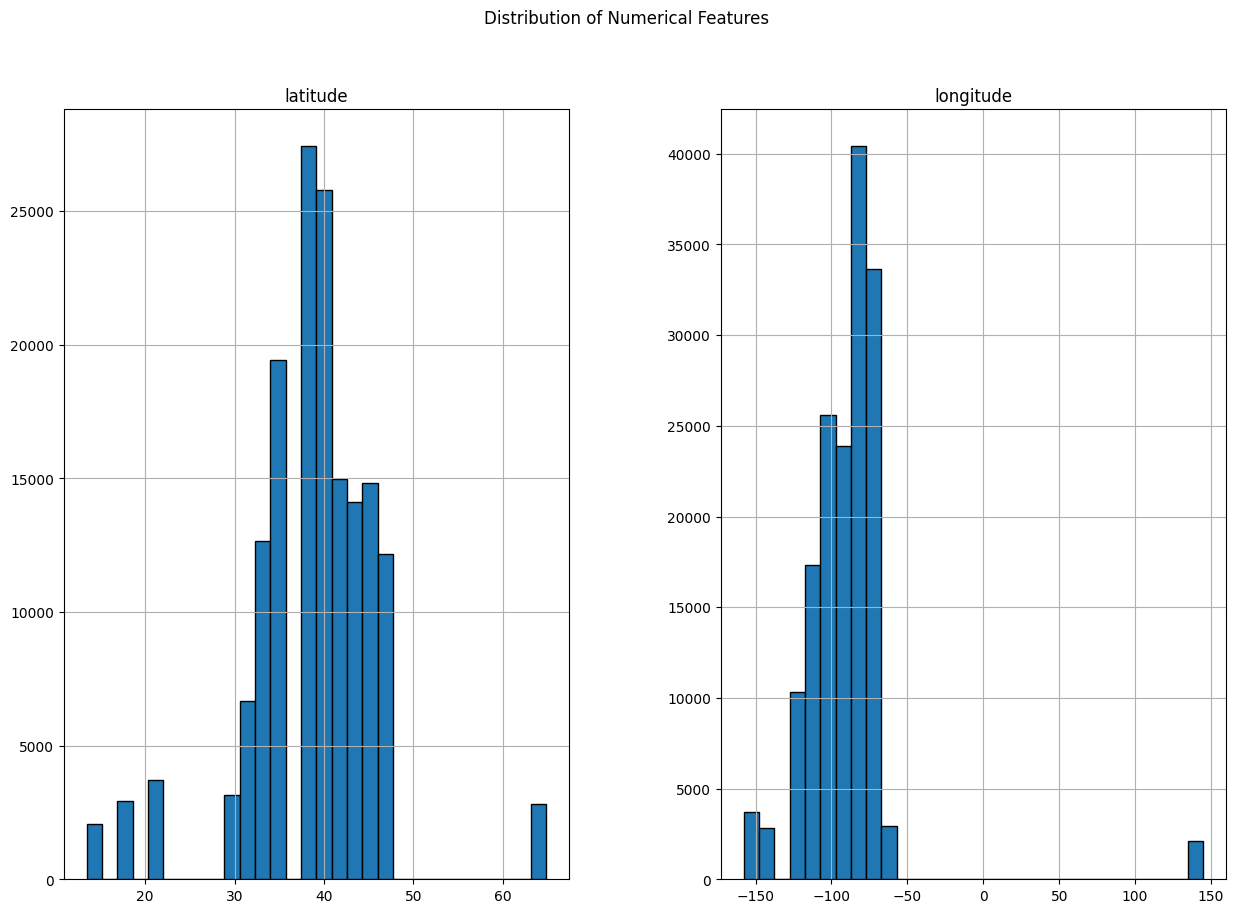

In [80]:
# Distribution of Numerical Features
# Select numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Plot histograms for numerical features
data[numerical_columns].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.show()

/var/folders/3p/1xq25tt55vz8j91n9rmh_vm80000gn/T/ipykernel_39274/3944120483.py:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


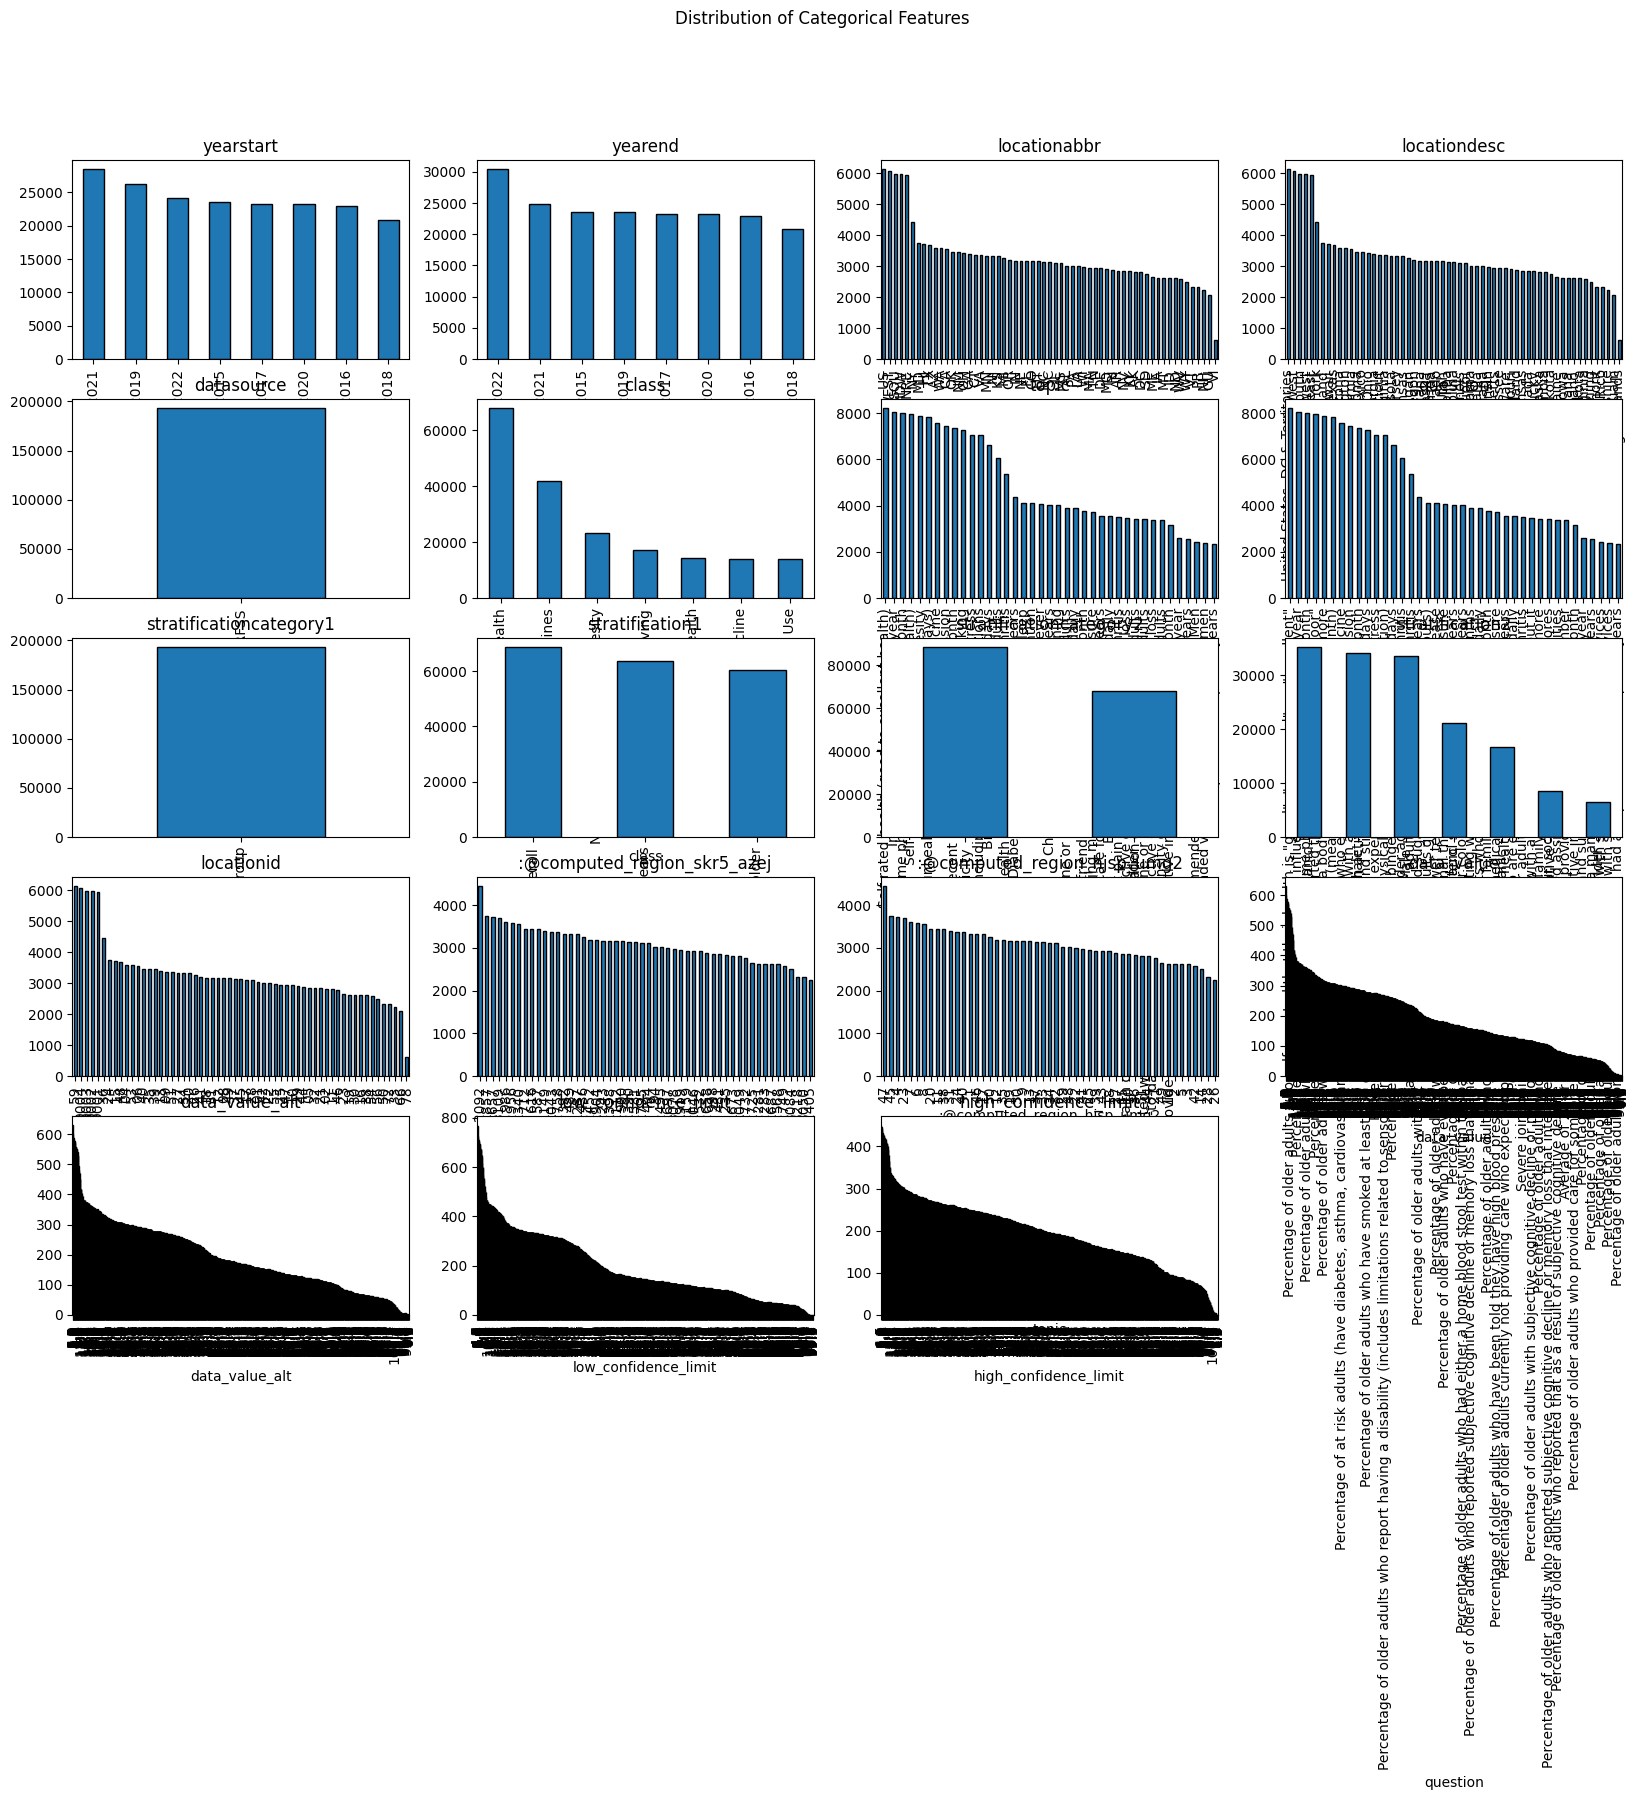

In [81]:
# Distribution of Categorical Features
# Select categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Plot bar charts for categorical features
plt.figure(figsize=(20, 15))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(5, 4, i)
    data[column].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(column)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.suptitle('Distribution of Categorical Features')
plt.show()


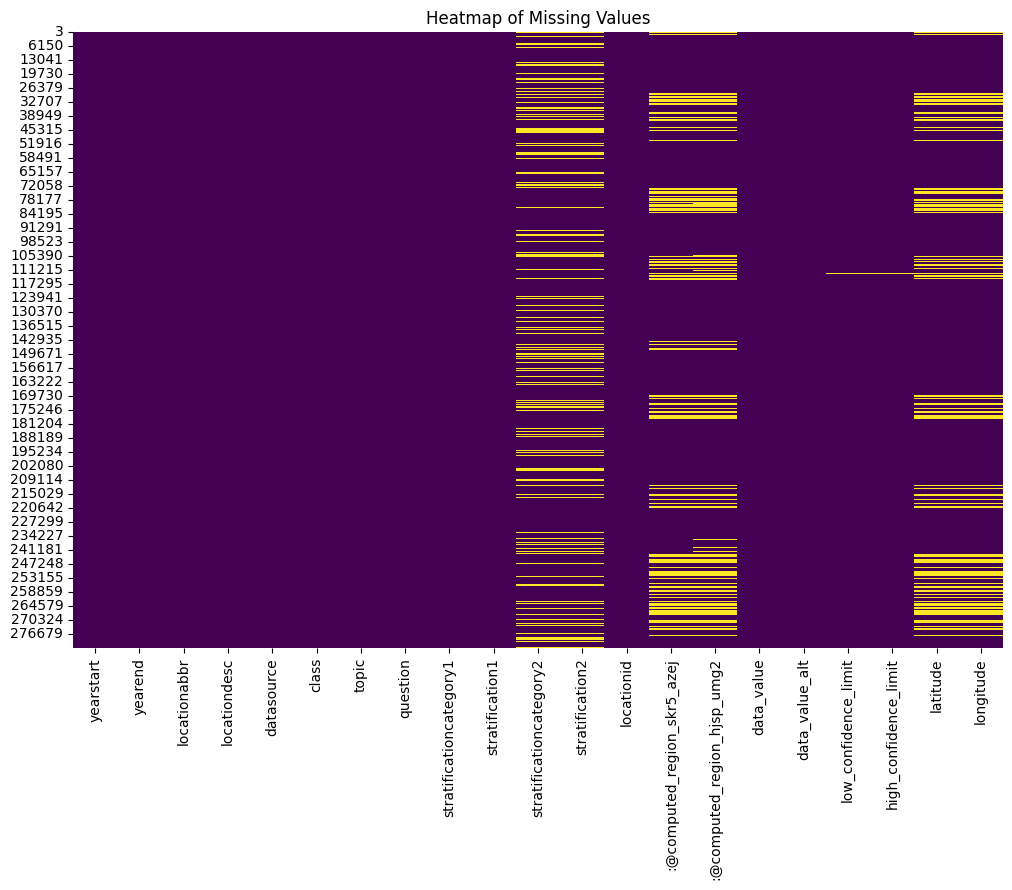

In [83]:
# Plot heatmap of missing values
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()


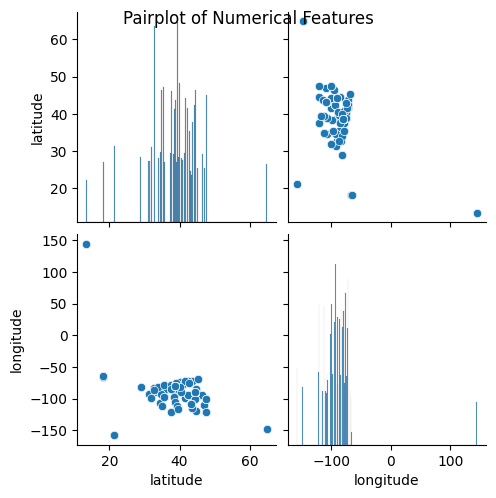

In [87]:
# Pairplot for Numerical Data
sns.pairplot(data[numerical_columns].dropna())
plt.suptitle('Pairplot of Numerical Features')
plt.show()


In [5]:
# Drop rows with missing target values
data = data.dropna(subset=['data_value'])

In [6]:
# Keep a copy of the original 'question' column for later use
questions = data['question'].copy()

In [7]:
def extract_coordinates(coords):
    if isinstance(coords, list) and len(coords) == 2:
        return coords[1], coords[0]
    return None, None

In [8]:
# Extract the latitude and longitude
data['latitude'], data['longitude'] = zip(*data['geolocation.coordinates'].apply(extract_coordinates))

data = data.drop(columns=['rowid', 'geolocation.type', 'geolocation.coordinates', 'data_value_unit', 'datavaluetypeid', 'data_value_type', 'data_value_footnote_symbol', 'data_value_footnote', 'classid', 'topicid', 'questionid', 'stratificationcategoryid1', 'stratificationid1', 'stratificationcategoryid2', 'stratificationid2'])

In [9]:
# Encode categorical variables
data_encoded = pd.get_dummies(data, columns=['locationabbr', 'locationdesc', 'datasource', 'class', 'topic', 'question', 'stratificationcategory1', 'stratification1', 'stratificationcategory2', 'stratification2'])

# Normalize numerical columns
scaler = StandardScaler()
data_encoded[['yearstart', 'yearend', 'data_value', 'latitude', 'longitude']] = scaler.fit_transform(data_encoded[['yearstart', 'yearend', 'data_value', 'latitude', 'longitude']])


In [10]:
# Separate features and target variable
X = data_encoded.drop(columns=['data_value'])
y = data_encoded['data_value']

# base line model

In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Identify columns with non-numeric data
non_numeric_columns = X_train.select_dtypes(include=['object']).columns

In [49]:
# One-hot encode remaining non-numeric columns in the entire dataset
X_train_encoded = pd.get_dummies(X_train, columns=non_numeric_columns)
X_test_encoded = pd.get_dummies(X_test, columns=non_numeric_columns)

# Ensure both train and test sets have the same columns after one-hot encoding
X_train_blm, X_test_blm = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [14]:
# Initialize and train the baseline model
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train_blm, y_train)

# Save the model
joblib.dump(baseline_model, 'baseline_model.pkl')

['baseline_model.pkl']

In [12]:
baseline_model = joblib.load('models_w_geo/baseline_model.pkl')

In [51]:
# Make predictions
y_pred = baseline_model.predict(X_test_blm)

In [19]:
# Evaluate the baseline model

# Mean Squared Error (MSE)
baseline_mse = mean_squared_error(y_test, y_pred)
print(f'Baseline Model MSE: {baseline_mse}')

# Mean Absolute Error (MAE)
baseline_mae = mean_absolute_error(y_test, y_pred)
print(f'Baseline Model MAE: {baseline_mae}')

# R-squared (Coefficient of Determination)
baseline_r2 = r2_score(y_test, y_pred)
print(f'Baseline Model R-squared: {baseline_r2}')

# Explained Variance Score
baseline_evs = explained_variance_score(y_test, y_pred)
print(f'Baseline Model EVS: {baseline_evs}')

Baseline Model MSE: 0.02205997538346899
Baseline Model MAE: 0.08461904002601216
Baseline Model R-squared: 0.9780719070363394
Baseline Model EVS: 0.9780739015062828


# BERT

In [52]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will b

In [53]:
# Tokenize the text data
text_data = data['question'].values
inputs = tokenizer(text_data.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)


In [19]:
# Function to generate BERT embeddings in batches
def generate_bert_embeddings_in_batches(model, tokenizer, texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # [CLS] token representation
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)


In [20]:
# Generate BERT embeddings in batches
bert_embeddings = generate_bert_embeddings_in_batches(bert_model, tokenizer, text_data, batch_size=32)

np.save('bert_embeddings.npy', bert_embeddings)

In [16]:
bert_embeddings = np.load('numpy array_w_geo/bert_embeddings.npy')

In [17]:
# Add BERT embeddings to the numerical and categorical features
X_combined = np.hstack((X.values, bert_embeddings))

In [56]:
# Split the combined data into training and testing sets
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [16]:
# Initialize and train the model
model_with_bert = RandomForestRegressor(random_state=42)
model_with_bert.fit(X_train_combined, y_train)

# Save the model
joblib.dump(model_with_bert, 'model_with_bert.pkl')

['model_with_bert.pkl']

In [13]:
model_with_bert = joblib.load('models_w_geo/model_with_bert.pkl')

In [58]:
# Make predictions
y_pred_with_bert = model_with_bert.predict(X_test_combined)

In [18]:
# Evaluate the model

# Mean Squared Error (MSE)
bert_mse = mean_squared_error(y_test, y_pred_with_bert)
print(f'BERT Model MSE: {bert_mse}')

# Mean Absolute Error (MAE)
bert_mae = mean_absolute_error(y_test, y_pred_with_bert)
print(f'BERT Model MAE: {bert_mae}')

# R-squared (Coefficient of Determination)
bert_r2 = r2_score(y_test, y_pred_with_bert)
print(f'BERT Model R-squared: {bert_r2}')

# Explained Variance Score
bert_evs = explained_variance_score(y_test, y_pred_with_bert)
print(f'BERT Model EVS: {bert_evs}')

BERT Model MSE: 9.304290063491669e-10
BERT Model MAE: 5.81108424420021e-07
BERT Model R-squared: 0.9999999990751335
BERT Model EVS: 0.999999999075162


# GPT4

In [26]:
openai.api_key = OPENAI_API_KEY

In [ ]:
# Function to generate embeddings using GPT-4
def get_gpt4_embeddings(text):
    response = openai.embeddings.create(
        model="text-embedding-ada-002",
        input=text
    )
    return response.data[0].embedding


In [ ]:
# Apply GPT-4 embeddings to relevant text columns
data['gpt4_embedding'] = data.apply(
    lambda row: get_gpt4_embeddings(
        f"{row['question']} {row['class']} {row['topic']} {row['stratification1']} {row['stratification2']}"
    ), axis=1
)

In [22]:
# Convert the list of embeddings to a numpy array for model input
gpt4_embeddings = np.array(data['gpt4_embedding'].tolist())

np.save('gpt4_embeddings.npy', gpt4_embeddings)

In [18]:
gpt4_embeddings = np.load('numpy array_w_geo/gpt4_embeddings.npy')

In [19]:
# # Add GPT-4 embeddings to the numerical and categorical features
X_gpt4 = np.hstack((X.values, gpt4_embeddings))


In [61]:
# Re-split the data into training and testing sets
X_train_gpt4, X_test_gpt4, y_train, y_test = train_test_split(X_gpt4, y, test_size=0.2, random_state=42)


In [25]:
# Initialize and train the RandomForestRegressor with GPT-4 embeddings
model_with_gpt4 = RandomForestRegressor(random_state=42)
model_with_gpt4.fit(X_train_gpt4, y_train)

# Save the model
joblib.dump(model_with_gpt4, 'model_with_gpt4.pkl')

['model_with_gpt4.pkl']

In [14]:
model_with_gpt4 = joblib.load('models_w_geo/model_with_gpt4.pkl')

In [63]:
# Make predictions
y_pred_with_gpt4 = model_with_gpt4.predict(X_test_gpt4)


In [27]:
# Evaluate the model
# Mean Squared Error (MSE)
gpt4_mse = mean_squared_error(y_test, y_pred_with_gpt4)
print(f'GPT-4 Model MSE: {gpt4_mse}')

# Mean Absolute Error (MAE)
gpt4_mae = mean_absolute_error(y_test, y_pred_with_gpt4)
print(f'GPT-4 Model MAE: {gpt4_mae}')

# R-squared (Coefficient of Determination)
gpt4_r2 = r2_score(y_test, y_pred_with_gpt4)
print(f'GPT-4 Model R-squared: {gpt4_r2}')

# Explained Variance Score
gpt4_evs = explained_variance_score(y_test, y_pred_with_gpt4)
print(f'GPT-4 Model EVS: {gpt4_evs}')

GPT-4 Model MSE: 1.2386139834617859e-09
GPT-4 Model MAE: 6.212203332749719e-07
GPT-4 Model R-squared: 0.9999999987687909
GPT-4 Model EVS: 0.9999999987688158


In [3]:
baseline_mse = 0.02205997538346899
baseline_mae = 0.08461904002601216
baseline_r2 = 0.9780719070363394

bert_mse = 9.304290063491669e-10
bert_mae = 5.81108424420021e-07
bert_r2 = 0.9999999990751335

gpt4_mse = 1.2386139834617859e-09
gpt4_mae = 6.212203332749719e-07
gpt4_r2 = 0.9999999987687909


In [6]:
metrics = {
    'Metric': ['MSE', 'MAE', 'R²'],  # Metrics on the x-axis
    'Baseline': [baseline_mse, baseline_mae, baseline_r2],  # Baseline model scores
    'BERT': [bert_mse, bert_mae, bert_r2],     # BERT model scores
    'GPT-4': [gpt4_mse, gpt4_mae, gpt4_r2]    # GPT-4 model scores
}

df = pd.DataFrame(metrics)

In [ ]:
# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(df['Metric']))  # Baseline bars
r2 = [x + bar_width for x in r1]   # BERT bars
r3 = [x + bar_width for x in r2]   # GPT-4 bars

# Create the bar chart
plt.figure(figsize=(10, 6))

plt.bar(r1, df['Baseline'], color='blue', width=bar_width, edgecolor='grey', label='Baseline')
plt.bar(r2, df['BERT'], color='orange', width=bar_width, edgecolor='grey', label='BERT')
plt.bar(r3, df['GPT-4'], color='green', width=bar_width, edgecolor='grey', label='GPT-4')

# Add labels and title
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Model Performance Comparison (MSE, MAE, R²)', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(df['Metric']))], df['Metric'])

# Add a legend
plt.legend()

# Display the chart
plt.show()


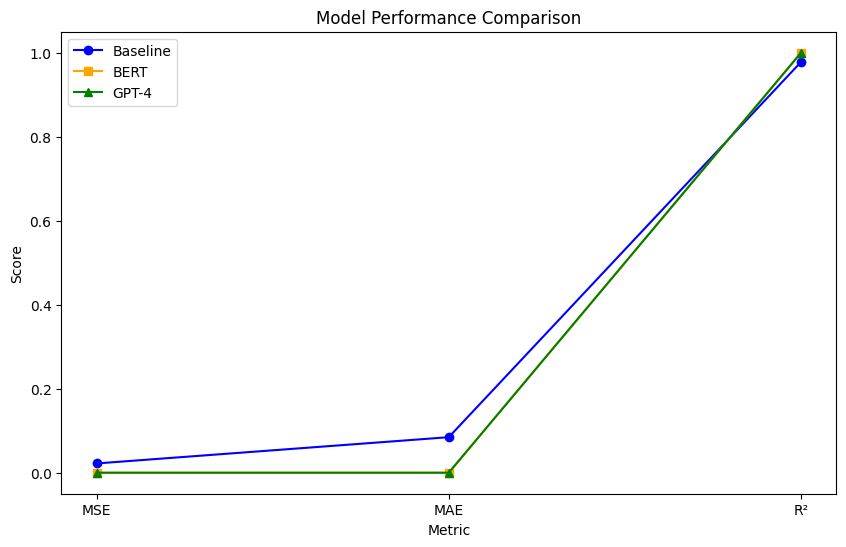

In [13]:
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot each model's metrics with different colors and markers
plt.plot(df['Metric'], df['Baseline'], marker='o', color='blue', label='Baseline')
plt.plot(df['Metric'], df['BERT'], marker='s', color='orange', label='BERT')
plt.plot(df['Metric'], df['GPT-4'], marker='^', color='green', label='GPT-4')

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()

# Display the chart
plt.show()


# 5-fold Cross-Validation

In [32]:
# Cross-validation for Baseline Model
baseline_cv_scores = cross_val_score(baseline_model, X, y, cv=5, scoring='neg_mean_squared_error')
baseline_cv_mse = -baseline_cv_scores.mean()
print(f'Baseline Model Cross-Validated MSE: {baseline_cv_mse}')

# Cross-validation for BERT Model
bert_cv_scores = cross_val_score(model_with_bert, X_combined, y, cv=5, scoring='neg_mean_squared_error')
bert_cv_mse = -bert_cv_scores.mean()
print(f'BERT Model Cross-Validated MSE: {bert_cv_mse}')

# Cross-validation for GPT-4 Model
gpt4_cv_scores = cross_val_score(model_with_gpt4, X_gpt4, y, cv=5, scoring='neg_mean_squared_error')
gpt4_cv_mse = -gpt4_cv_scores.mean()
print(f'GPT-4 Model Cross-Validated MSE: {gpt4_cv_mse}')


Baseline Model Cross-Validated MSE: 9.068100290991943e-10
BERT Model Cross-Validated MSE: 1.2772328795174172e-09
GPT-4 Model Cross-Validated MSE: 2.029886562795352e-09


In [15]:
# Cross-validation for Baseline Model
baseline_cv_scores = cross_val_score(baseline_model, X, y, cv=10, scoring='neg_mean_squared_error')
baseline_cv_mse = -baseline_cv_scores.mean()
print(f'Baseline Model 10-Fold Cross-Validated MSE: {baseline_cv_mse}')


Baseline Model 10-Fold Cross-Validated MSE: 4.5160273117380427e-10


NameError: name 'X_combined' is not defined

In [20]:
# Cross-validation for BERT Model
bert_cv_scores = cross_val_score(model_with_bert, X_combined, y, cv=10, scoring='neg_mean_squared_error')
bert_cv_mse = -bert_cv_scores.mean()
print(f'BERT Model 10-Fold Cross-Validated MSE: {bert_cv_mse}')

# Cross-validation for GPT-4 Model
gpt4_cv_scores = cross_val_score(model_with_gpt4, X_gpt4, y, cv=10, scoring='neg_mean_squared_error')
gpt4_cv_mse = -gpt4_cv_scores.mean()
print(f'GPT-4 Model 10-Fold Cross-Validated MSE: {gpt4_cv_mse}')

BERT Model 10-Fold Cross-Validated MSE: 9.69927555593492e-10
GPT-4 Model 10-Fold Cross-Validated MSE: 1.7202102144727017e-09


In [18]:
#baseline_cv_mse = 9.068100290991943e-10
baseline_cv_mse = 0.02229099194390681
bert_cv_mse = 1.2772328795174172e-09
gpt4_cv_mse = 2.029886562795352e-09

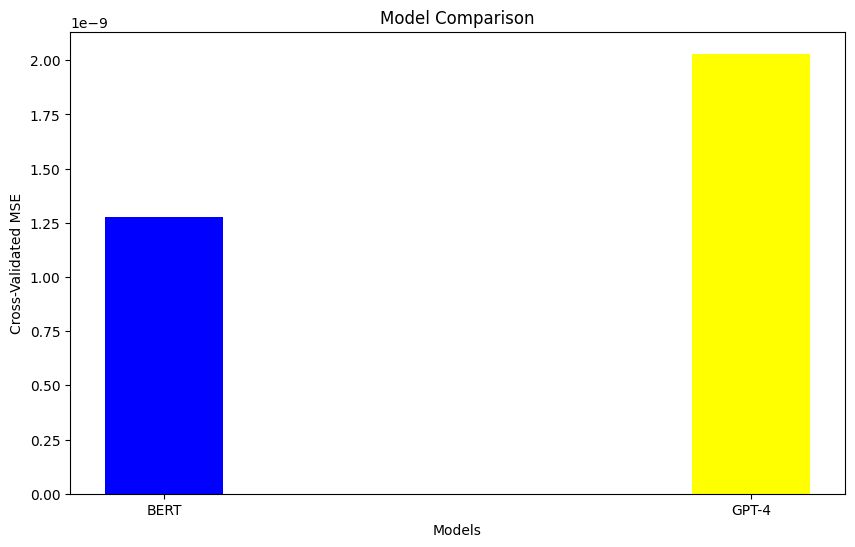

In [29]:
# Data
models = ['BERT', 'GPT-4']
scores = [bert_cv_mse, gpt4_cv_mse]

# Set the width of the bars
bar_width = 0.2

# Plotting
# Set the figure size for better visibility
plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['blue', 'yellow', 'green'], width=bar_width)
plt.xlabel('Models')
plt.ylabel('Cross-Validated MSE')
plt.title('Model Comparison')
plt.show()

# Error Analysis

In [64]:
np.save('questions.npy', questions)
np.save('y_test.npy', y_test)
np.save('y_pred.npy', y_pred)
np.save('y_pred_with_bert.npy', y_pred_with_bert)
np.save('y_pred_with_gpt4.npy', y_pred_with_gpt4)

In [65]:
baseline_residuals = y_test - y_pred
bert_residuals = y_test - y_pred_with_bert
gpt4_residuals = y_test - y_pred_with_gpt4

np.save('baseline_residuals.npy', baseline_residuals)
np.save('bert_residuals.npy', bert_residuals)
np.save('gpt4_residuals.npy', gpt4_residuals)

## 1.Residual Plot

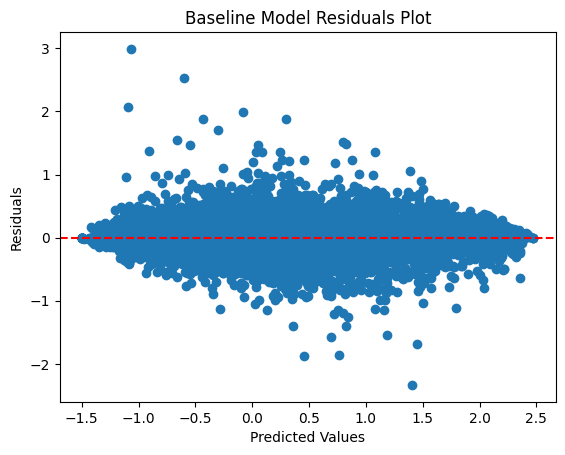

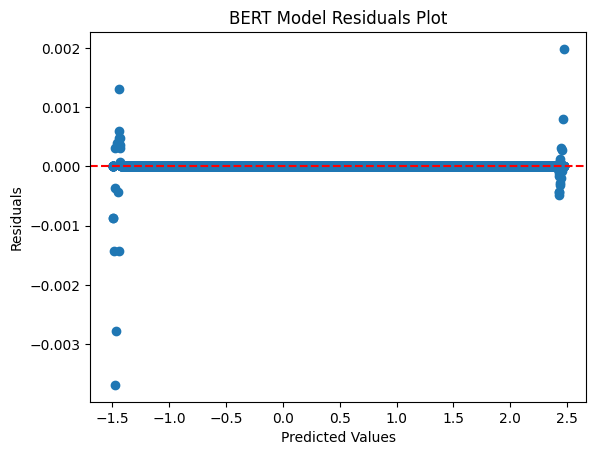

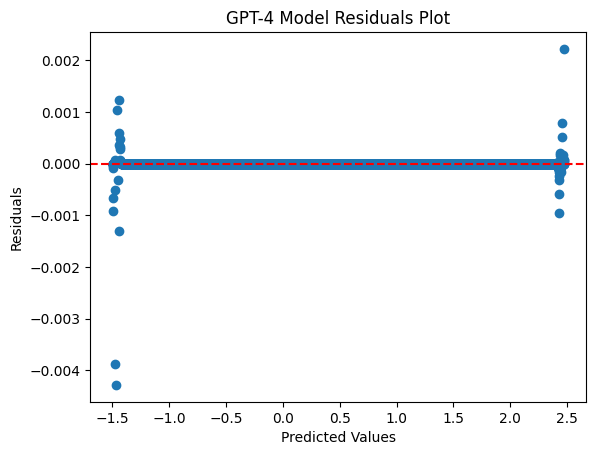

In [33]:
# Baseline Model Residuals
baseline_residuals = y_test - y_pred
plt.scatter(y_pred, baseline_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Baseline Model Residuals Plot')
plt.show()

# BERT Model Residuals
bert_residuals = y_test - y_pred_with_bert
plt.scatter(y_pred_with_bert, bert_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('BERT Model Residuals Plot')
plt.show()

# GPT-4 Model Residuals
gpt4_residuals = y_test - y_pred_with_gpt4
plt.scatter(y_pred_with_gpt4, gpt4_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('GPT-4 Model Residuals Plot')
plt.show()


## 2.Error Distribution

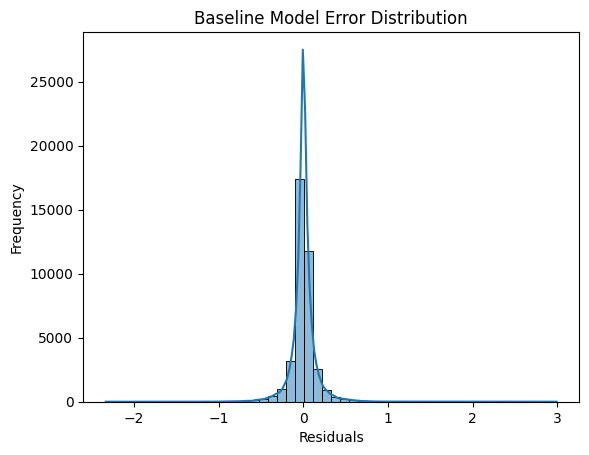

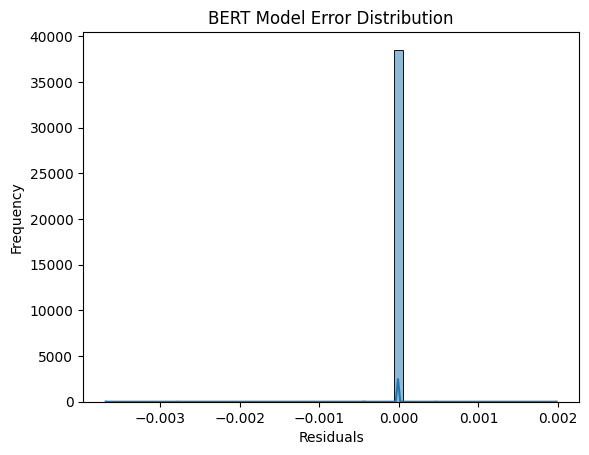

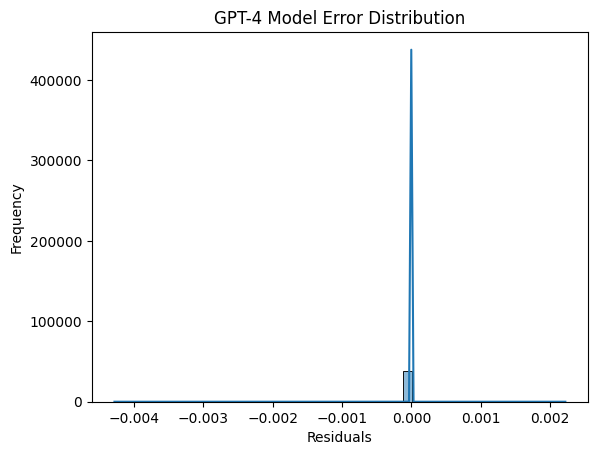

In [70]:
# Error Distribution for Baseline Model
sns.histplot(baseline_residuals, bins=50, kde=True)
plt.title('Baseline Model Error Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Error Distribution for BERT Model
sns.histplot(bert_residuals, bins=50, kde=True)
plt.title('BERT Model Error Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Error Distribution for GPT-4 Model
sns.histplot(gpt4_residuals, bins=50, kde=True)
plt.title('GPT-4 Model Error Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


## 3.Error by Group

In [74]:
# Create a DataFrame to analyze errors
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Baseline': y_pred,
    'Predicted_BERT': y_pred_with_bert,
    'Predicted_GPT4': y_pred_with_gpt4
})

location_columns = [col for col in X_test.columns if 'locationdesc_' in col]
error_df['Location'] = X_test[location_columns].idxmax(axis=1).str.replace('locationdesc_', '')

# Calculate the absolute errors for each model
error_df['Error_Baseline'] = np.abs(error_df['Actual'] - error_df['Predicted_Baseline'])
error_df['Error_BERT'] = np.abs(error_df['Actual'] - error_df['Predicted_BERT'])
error_df['Error_GPT4'] = np.abs(error_df['Actual'] - error_df['Predicted_GPT4'])

# Group by location and calculate mean error
error_by_location = error_df.groupby('Location').mean()[['Error_Baseline', 'Error_BERT', 'Error_GPT4']]
print(error_by_location.sort_values(by='Error_Baseline'))


                                 Error_Baseline    Error_BERT    Error_GPT4
Location                                                                   
New Hampshire                          0.043582  1.217546e-15  1.208018e-15
South Carolina                         0.054079  1.162500e-15  1.158917e-15
Vermont                                0.055288  1.208696e-15  1.206095e-15
United States, DC & Territories        0.058323  1.103791e-15  1.096823e-15
Alabama                                0.059666  9.720937e-07  9.720937e-07
West Virginia                          0.060531  8.862887e-07  7.385740e-07
Missouri                               0.061884  1.160000e-15  1.150706e-15
Wyoming                                0.062384  1.236269e-15  1.229124e-15
Iowa                                   0.065418  1.159486e-15  1.159198e-15
Utah                                   0.066590  2.217098e-06  2.155512e-06
Virginia                               0.068814  1.261094e-07  1.261094e-07
Indiana     

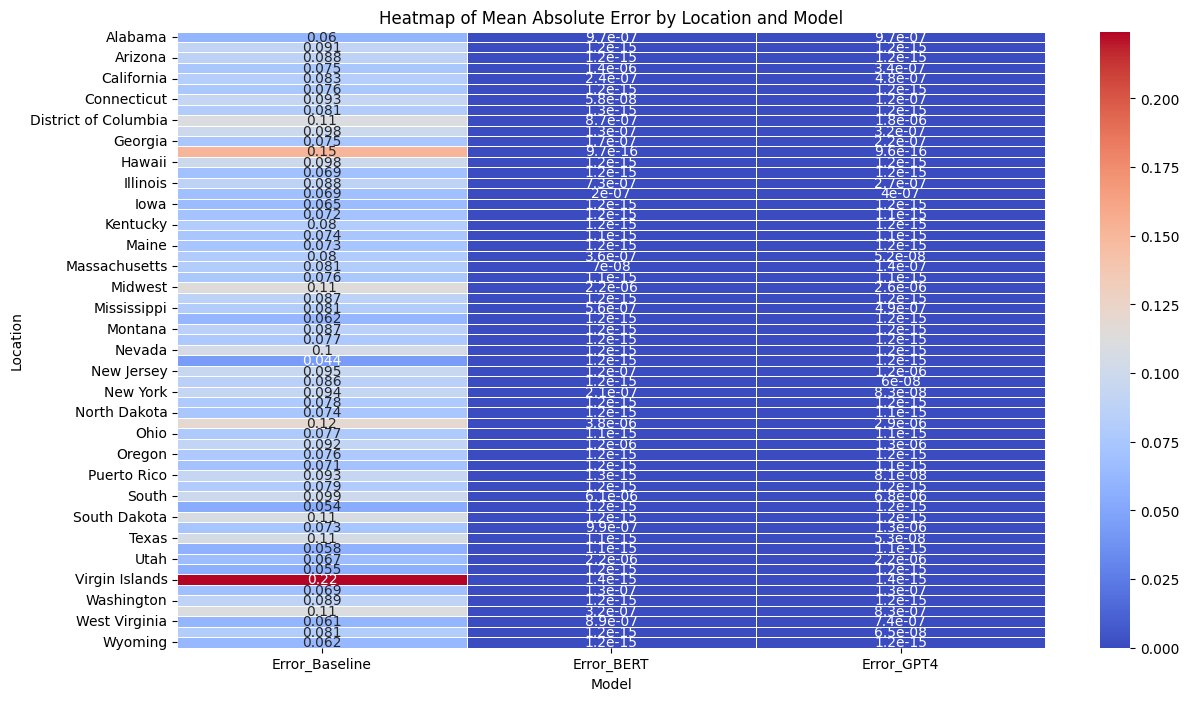

In [77]:
plt.figure(figsize=(14, 8))
sns.heatmap(error_by_location, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Mean Absolute Error by Location and Model')
plt.xlabel('Model')
plt.ylabel('Location')
plt.show()